In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_validate, RandomizedSearchCV, train_test_split

In [2]:
import optuna
import xgboost as xgb

In [3]:
# display settings

pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.width', 500)

In [4]:
df = pd.read_csv("output.csv", encoding="utf16")

In [5]:
def check_df(dataframe, head=5):
    print("INFO".center(70,'='))
    print(dataframe.info())

    print("SHAPE".center(70,'='))
    print('Rows: {}'.format(dataframe.shape[0]))
    print('Columns: {}'.format(dataframe.shape[1]))

    print("TYPES".center(70,'='))
    print(dataframe.dtypes)

    print("HEAD".center(70, '='))
    print(dataframe.head(head))

    print("TAIL".center(70,'='))
    print(dataframe.tail(head))

    print("NULL".center(70,'='))
    print(dataframe.isnull().sum())

    print("QUANTILES".center(70,'='))
    print(dataframe.describe([0.05,0.25, 0.75,0.90,0.99]).T)

In [6]:
check_df(df)

=================================INFO=================================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39140 entries, 0 to 39139
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Fiyat         39140 non-null  int64 
 1   Marka         39140 non-null  object
 2   Seri          39140 non-null  object
 3   Model         39140 non-null  object
 4   Yıl           39140 non-null  int64 
 5   Yakıt Tipi    39140 non-null  object
 6   Vites Tipi    39140 non-null  object
 7   Motor Gücü    39140 non-null  int64 
 8   Motor Hacmi   39140 non-null  int64 
 9   Kilometre     39140 non-null  int64 
 10  Boya-değişen  39140 non-null  object
dtypes: int64(5), object(6)
memory usage: 3.3+ MB
None
================================SHAPE=================================
Rows: 39140
Columns: 11
================================TYPES=================================
Fiyat            int64
Marka           object
Seri   

In [7]:
def data_prep(dataframe):
  dataframe.drop(dataframe[(dataframe["Kilometre"] == 0) & (dataframe["Yıl"] < 2021)].index, axis=0, inplace=True)
  dataframe.drop(dataframe[(dataframe["Motor Gücü"] == 0) | (dataframe["Motor Hacmi"] == 0)].index, axis=0, inplace=True)
 

  # Boya-değişen sütununu düzenleme v iki ayrı sütun olarak ekleme
  boya_sutunu = []
  degisen_sutunu = []

  for veri in dataframe["Boya-değişen"]:   
    if ("değişen" in veri) & ("boyalı" in veri):
        sayi = veri.split()
        degisen_sutunu.append(sayi[0])
        boya_sutunu.append(sayi[2])
        
    elif ("boyalı" in veri) & (veri not in "Tamamı boyalı") :
            sayi = veri.split()[0]
            boya_sutunu.append(int(sayi))
            degisen_sutunu.append(0)
            
    elif ("değişen" in veri) & (veri not in "Tamamı değişmiş"):
            sayi = veri.split()[0]
            degisen_sutunu.append(int(sayi))
            boya_sutunu.append(0)
            
    else:
        if veri == "Tamamı değişmiş":
            boya_sutunu.append(0)
            degisen_sutunu.append(12)
        elif veri == "Tamamı boyalı":
            boya_sutunu.append(12)
            degisen_sutunu.append(0)
            
        elif veri == "Tamamı orjinal":
            boya_sutunu.append(0)
            degisen_sutunu.append(0)
            
        elif veri == "Belirtilmemiş":
            boya_sutunu.append(np.nan)
            degisen_sutunu.append(np.nan)
  dataframe["Boya"] = boya_sutunu
  dataframe["Değişen"] = degisen_sutunu

  # Tipi object olan değişkenleri int yapma
  dataframe['Boya'] = pd.to_numeric(dataframe['Boya'], errors='coerce').astype('Int64')
  dataframe['Değişen'] = pd.to_numeric(dataframe['Değişen'], errors='coerce').astype('Int64')

  dataframe.drop("Boya-değişen", axis=1, inplace=True)

  # Marka bazında sayısı 100'den küçük olanları sil
  dataframe = dataframe[dataframe["Marka"].isin(dataframe["Marka"].value_counts()[dataframe["Marka"].value_counts() >= 100].index)]

  dataframe.drop(dataframe[(dataframe["Fiyat"] < 50000) & (dataframe["Yıl"] > 2009)].index, axis=0, inplace=True)

  #165000000 olanı sil
  dataframe.drop(dataframe[(dataframe["Marka"]=="Mercedes - Benz") & (dataframe["Fiyat"] > 50000000)].index, axis=0, inplace=True)

  dataframe.drop(dataframe[(dataframe["Kilometre"] > 3000000) & (dataframe["Marka"]=="Tofaş")].index, axis=0, inplace=True)

  return dataframe

In [8]:
df = data_prep(df)

C:\Users\senab\AppData\Local\Temp\ipykernel_7376\1233648156.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.drop(dataframe[(dataframe["Fiyat"] < 50000) & (dataframe["Yıl"] > 2009)].index, axis=0, inplace=True)
C:\Users\senab\AppData\Local\Temp\ipykernel_7376\1233648156.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.drop(dataframe[(dataframe["Marka"]=="Mercedes - Benz") & (dataframe["Fiyat"] > 50000000)].index, axis=0, inplace=True)
C:\Users\senab\AppData\Local\Temp\ipykernel_7376\1233648156.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame



In [9]:
df.head(10)

,Fiyat,Marka,Seri,Model,Yıl,Yakıt Tipi,Vites Tipi,Motor Gücü,Motor Hacmi,Kilometre,Boya,Değişen
0,252250,Alfa Romeo,156,2.0 JTS Distinctive,2004,LPG & Benzin,Yarı Otomatik,165,1970,250000,<NA>,<NA>
1,480000,Alfa Romeo,Giulietta,1.6 JTD Distinctive,2011,Dizel,Düz,105,1598,185000,<NA>,<NA>
2,375000,Alfa Romeo,MiTo,1.4 T Distinctive,2009,Benzin,Düz,155,1368,151000,<NA>,<NA>
3,226000,Alfa Romeo,147,1.6 TS Progression,2004,LPG & Benzin,Düz,120,1598,271500,<NA>,<NA>
4,439000,Alfa Romeo,Giulietta,1.6 JTD Progression Plus,2012,Dizel,Düz,105,1598,280000,8,0
5,454900,Alfa Romeo,Giulietta,1.4 TB MultiAir Distinctive,2011,Benzin,Düz,120,1368,167245,10,0
6,570000,Alfa Romeo,Giulietta,1.4 TB MultiAir Distinctive,2012,Benzin,Otomatik,170,1368,140000,2,0
7,160000,Alfa Romeo,146,1.4 TS Ritmo,2000,LPG & Benzin,Düz,103,1370,279000,12,0
8,849990,Alfa Romeo,Giulietta,1.4 TB MultiAir Distinctive,2015,Benzin,Otomatik,170,1368,65000,<NA>,<NA>
9,210000,Alfa Romeo,147,1.6 TS Progression,2004,LPG & Benzin,Düz,120,1598,172000,3,0


In [10]:
df.shape

(37180, 12)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37180 entries, 0 to 39139
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Fiyat        37180 non-null  int64 
 1   Marka        37180 non-null  object
 2   Seri         37180 non-null  object
 3   Model        37180 non-null  object
 4   Yıl          37180 non-null  int64 
 5   Yakıt Tipi   37180 non-null  object
 6   Vites Tipi   37180 non-null  object
 7   Motor Gücü   37180 non-null  int64 
 8   Motor Hacmi  37180 non-null  int64 
 9   Kilometre    37180 non-null  int64 
 10  Boya         23201 non-null  Int64 
 11  Değişen      23201 non-null  Int64 
dtypes: Int64(2), int64(5), object(5)
memory usage: 3.8+ MB


In [12]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car,num_but_cat

In [13]:
cat_cols, num_cols, cat_but_car,num_but_cat = grab_col_names(df)

Observations: 37180
Variables: 12
cat_cols: 2
num_cols: 7
cat_but_car: 3
num_but_cat: 0


In [14]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                       "Ratio": 100*dataframe[col_name].value_counts() / len(dataframe)}))
    
    print("===============================")
    
    if plot:
        sns.countplot(x = dataframe[col_name], data = dataframe)
        plt.show()

              Yakıt Tipi  Ratio
Dizel              15191 40.858
LPG & Benzin       13833 37.205
Benzin              8156 21.937


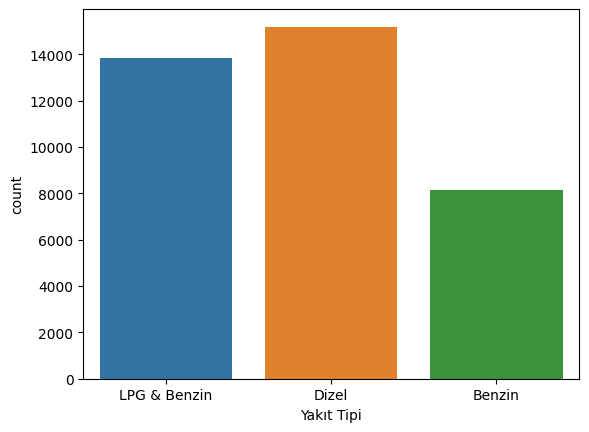

               Vites Tipi  Ratio
Düz                 22772 61.248
Otomatik             8814 23.706
Yarı Otomatik        5594 15.046


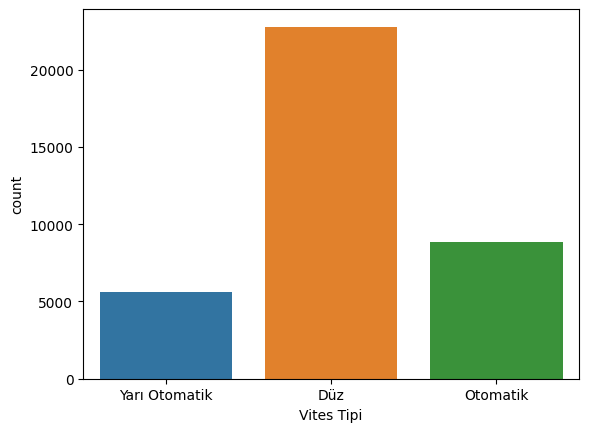

In [15]:
for col in cat_cols:
    cat_summary(df, col, plot = True)

In [16]:
def num_summary(dataframe, numerical_col, target,plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        #plt.hist(dataframe[numerical_col])
        #dataframe[numerical_col].hist(bins=20)
        sns.scatterplot(data=dataframe, x=col, y=target)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

count      37180.000
mean      554880.739
std       691540.145
min        17500.000
5%        130000.000
10%       175000.000
20%       245980.000
30%       302000.000
40%       360000.000
50%       423000.000
60%       493850.000
70%       589900.000
80%       715000.000
90%       960000.000
95%      1310000.000
99%      2566050.000
max     23850000.000
Name: Fiyat, dtype: float64


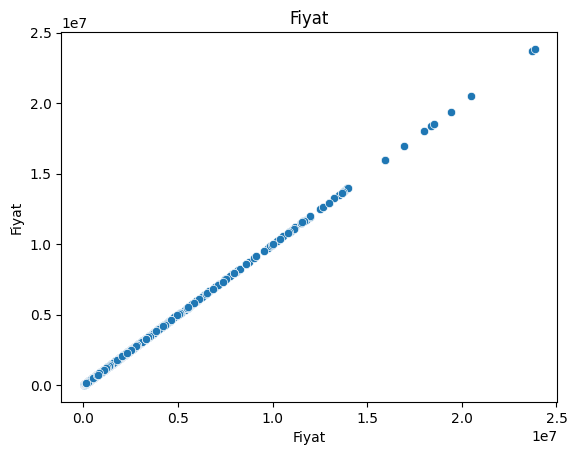

count   37180.000
mean     2009.051
std         7.993
min      1955.000
5%       1993.000
10%      1997.000
20%      2002.000
30%      2006.000
40%      2008.000
50%      2011.000
60%      2012.000
70%      2014.000
80%      2016.000
90%      2018.000
95%      2020.000
99%      2022.000
max      2023.000
Name: Yıl, dtype: float64


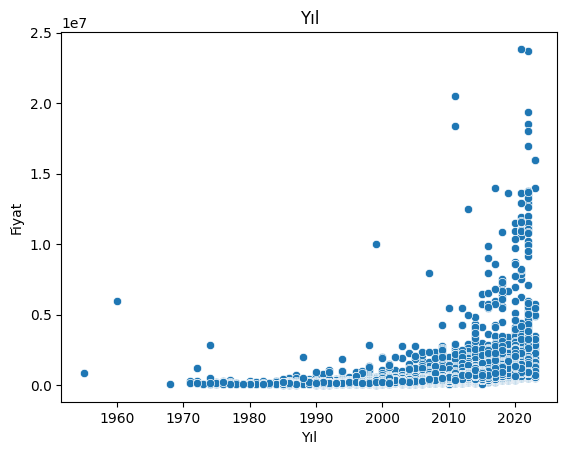

count   37180.000
mean      110.071
std        39.221
min        39.000
5%         70.000
10%        75.000
20%        83.000
30%        90.000
40%        95.000
50%       102.000
60%       110.000
70%       118.000
80%       125.000
90%       152.000
95%       177.000
99%       245.000
max      1599.000
Name: Motor Gücü, dtype: float64


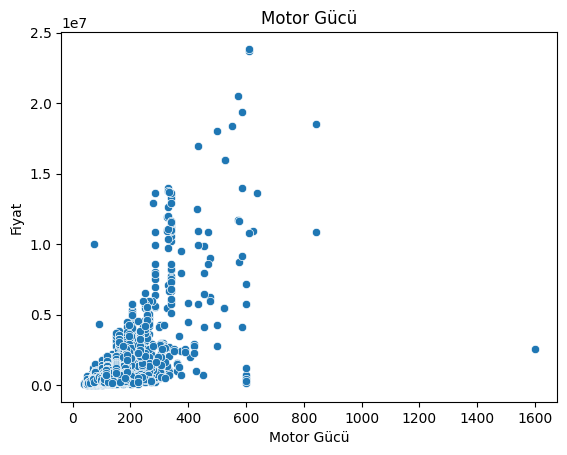

count   37180.000
mean     1545.317
std       305.418
min       133.000
5%       1200.000
10%      1248.000
20%      1368.000
30%      1398.000
40%      1493.000
50%      1560.000
60%      1587.000
70%      1597.000
80%      1598.000
90%      1896.000
95%      1995.000
99%      2967.000
max      6208.000
Name: Motor Hacmi, dtype: float64


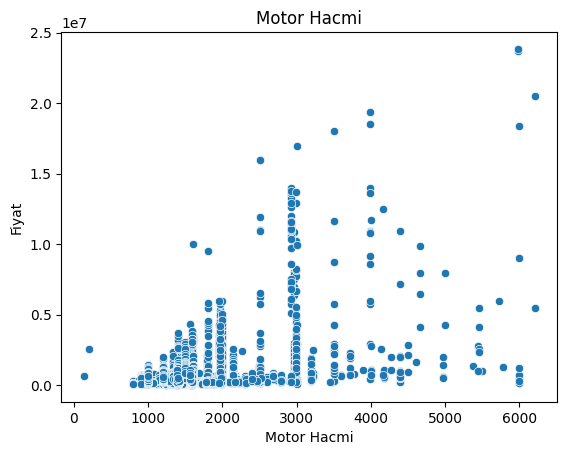

count     37180.000
mean     186039.033
std      107154.205
min           0.000
5%        33887.350
10%       62000.000
20%       99000.000
30%      129000.000
40%      155533.000
50%      180000.000
60%      205000.000
70%      232000.000
80%      263000.000
90%      306050.000
95%      350000.000
99%      452210.000
max     3600018.000
Name: Kilometre, dtype: float64


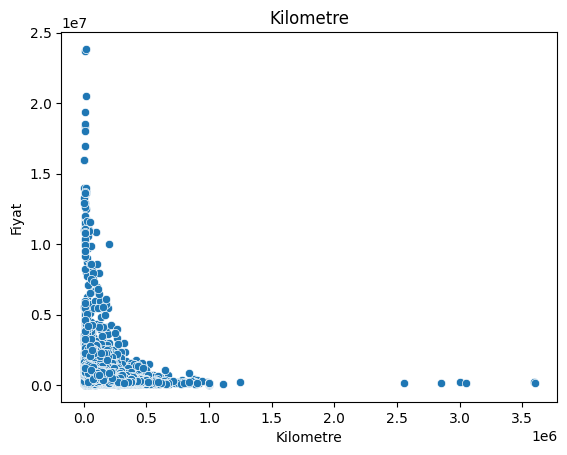

count   23201.000
mean        2.856
std         3.388
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         0.000
40%         1.000
50%         2.000
60%         3.000
70%         4.000
80%         5.000
90%         8.000
95%        11.000
99%        12.000
max        12.000
Name: Boya, dtype: Float64


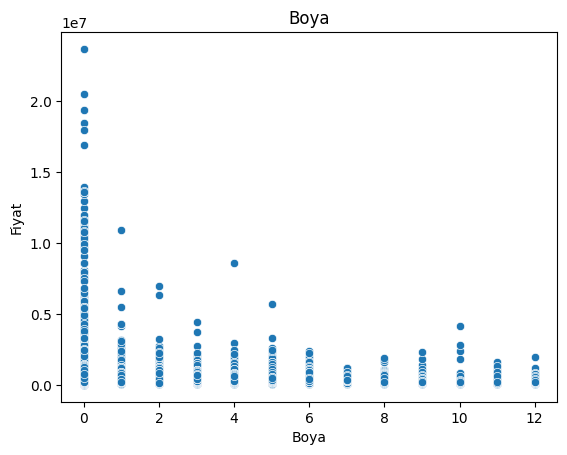

count   23201.000
mean        0.673
std         1.016
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         0.000
40%         0.000
50%         0.000
60%         0.000
70%         1.000
80%         1.000
90%         2.000
95%         3.000
99%         4.000
max        12.000
Name: Değişen, dtype: Float64


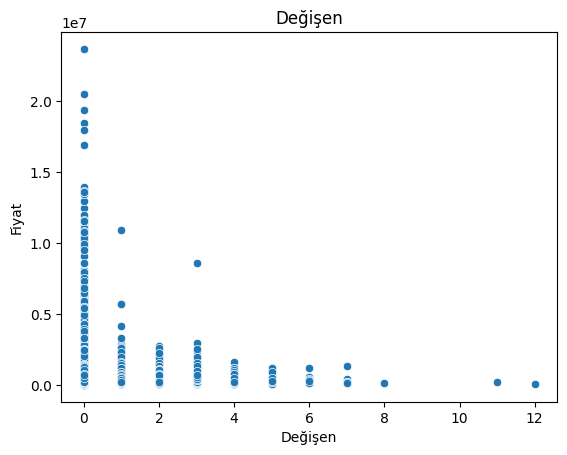

In [17]:
for col in num_cols:
    num_summary(df, col,"Fiyat", plot=True)

C:\Users\senab\AppData\Local\Temp\ipykernel_7376\324059130.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, fmt=".2f",ax=ax,cmap="coolwarm")


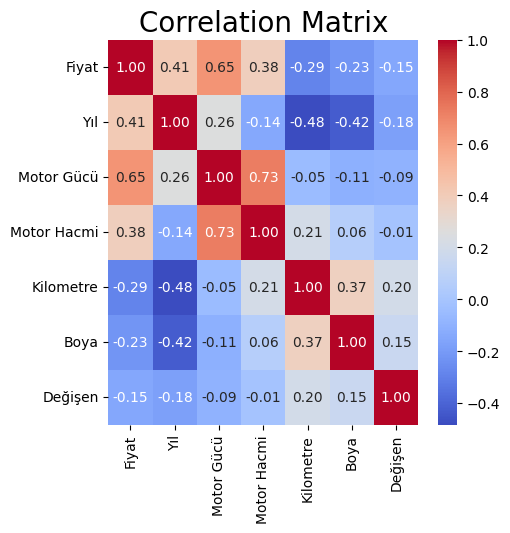

In [18]:
f,ax=plt.subplots(figsize=[5,5])
sns.heatmap(df.corr(), annot=True, fmt=".2f",ax=ax,cmap="coolwarm")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

In [19]:
def one_hot_encoder(dataframe, categorical_col, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns = categorical_col, drop_first=drop_first)
    return dataframe

In [20]:
cat_col_marka = ["Seri","Model","Yakıt Tipi","Vites Tipi"]

In [21]:
def robust_scaler(dataframe, numerical_col):
  rs = RobustScaler()
  dataframe[numerical_col] = rs.fit_transform(dataframe[numerical_col])

  return dataframe

In [23]:
num_cols = ['Yıl','Motor Gücü', 'Motor Hacmi', 'Kilometre']
num_cols

['Yıl', 'Motor Gücü', 'Motor Hacmi', 'Kilometre']

In [24]:
df['Marka'] = df['Marka'].str.replace('Mercedes - Benz', 'Mercedes')

In [25]:
df['Marka'].unique()

array(['Alfa Romeo', 'Audi', 'BMW', 'Chevrolet', 'Citroen', 'Dacia',
       'Fiat', 'Ford', 'Honda', 'Hyundai', 'Kia', 'Lada', 'Mazda',
       'Mercedes', 'MINI', 'Mitsubishi', 'Nissan', 'Opel', 'Peugeot',
       'Renault', 'Seat', 'Skoda', 'Suzuki', 'Tofaş', 'Toyota',
       'Volkswagen', 'Volvo'], dtype=object)

In [26]:
df = robust_scaler(df, num_cols)

In [27]:
df.head()

,Fiyat,Marka,Seri,Model,Yıl,Yakıt Tipi,Vites Tipi,Motor Gücü,Motor Hacmi,Kilometre,Boya,Değişen
0,252250,Alfa Romeo,156,2.0 JTS Distinctive,-0.636,LPG & Benzin,Yarı Otomatik,1.750,1.971,0.524,<NA>,<NA>
1,480000,Alfa Romeo,Giulietta,1.6 JTD Distinctive,0.000,Dizel,Düz,0.083,0.183,0.037,<NA>,<NA>
2,375000,Alfa Romeo,MiTo,1.4 T Distinctive,-0.182,Benzin,Düz,1.472,-0.923,-0.217,<NA>,<NA>
3,226000,Alfa Romeo,147,1.6 TS Progression,-0.636,LPG & Benzin,Düz,0.500,0.183,0.685,<NA>,<NA>
4,439000,Alfa Romeo,Giulietta,1.6 JTD Progression Plus,0.091,Dizel,Düz,0.083,0.183,0.749,8,0


In [29]:
# Marka bazında ayrı excel dosyaları oluşturma
for marka in df["Marka"].unique():
    name = marka + ".xlsx"
    df[df["Marka"] == marka].to_excel("markaFile/"+name)

In [30]:
# one-hot encoding ve marka marka ayırma
for marka in df["Marka"].unique():
    name = marka + ".xlsx"
    df_marka = pd.read_excel("markaFile/"+name, sheet_name="Sheet1")
    df_marka.drop("Marka",axis=1,inplace=True)
    df_marka.drop("Unnamed: 0",axis=1,inplace=True)
    df_marka = one_hot_encoder(df_marka, cat_col_marka)
    df_marka.to_excel("markaFile/"+name)

In [ ]:
# MODELLEME

In [17]:
def set_model(model_list, X_train, X_test, y_train, y_test):
    dataf = pd.DataFrame()

    for i in range(len(model_list)):
        algo_name = model_list[i][0]
        algo = model_list[i][1]

        model = algo.fit(X_train, y_train)

        cv_result = cross_val_score(model,
                                    X_train, y_train,
                                    cv=5,
                                    scoring="neg_mean_squared_error")

        y_pred = model.predict(X_test)
        rmse = np.mean(np.sqrt(-cv_result))
        data_list = {"Model": algo_name,
                     "TestDeger": rmse,
                     "MSE":mean_squared_error(y_test, y_pred),
                     "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
                     "MAE": mean_absolute_error(y_test, y_pred)}
        dataf = dataf.append(data_list, ignore_index=True)

    return dataf

In [18]:
models = []
#models.append(('Gradient Boosting Regressor', GradientBoostingRegressor()))
models.append(('XGBModel', XGBRegressor(objective="reg:squarederror",use_label_encoder=False)))
#models.append(('LGBMModel', LGBMRegressor(use_missing=False)))
#models.append(('LRModel', LinearRegression()))
#models.append(('RFModel', RandomForestRegressor()))

In [19]:
df2 = pd.read_excel("markaFile/Alfa Romeo.xlsx",sheet_name="Sheet1")

In [ ]:
char_map = {
    'ç': 'c',
    'ğ': 'g',
    'ı': 'i',
    'ö': 'o',
    'ş': 's',
    'ü': 'u',
    'Ç': 'C',
    'Ğ': 'G',
    'İ': 'I',
    'Ö': 'O',
    'Ş': 'S',
    'Ü': 'U'
}

df2 = df2.rename(columns=lambda x: unidecode.unidecode(x).translate(str.maketrans(char_map)))

In [ ]:
df2 = df2.rename(columns = {"Yıl":"Yil", "Değişen":"Degisen","Motor Gücü":"Motor Gucu"})

In [22]:
df2.head()

,Unnamed: 0,Fiyat,Yıl,Motor Gücü,Motor Hacmi,Kilometre,Boya,Değişen,Seri_146,Seri_147,Seri_156,Seri_159,Seri_164,Seri_166,Seri_GT,Seri_Giulietta,Seri_MiTo,Model_1.4 T Distinctive,Model_1.4 T MultiAir Quadrifoglio Verde,Model_1.4 TB Distinctive,Model_1.4 TB MultiAir Distinctive,Model_1.4 TB MultiAir Progression Pluse,Model_1.4 TB MultiAir Super TCT,Model_1.4 TB Progression Plus,Model_1.4 TS,Model_1.4 TS Ritmo,Model_1.4 TS STD,Model_1.6,Model_1.6 JTD Distinctive,Model_1.6 JTD Progression,Model_1.6 JTD Progression Plus,Model_1.6 JTD Super TCT,Model_1.6 JTDM-2,Model_1.6 JTDM-2 Sprint,Model_1.6 L,Model_1.6 TS,Model_1.6 TS Black Line,Model_1.6 TS Distinctive,Model_1.6 TS Progression,Model_1.9 JTD Distinctive,Model_1.9 JTD Distinctive Plus,Model_1.9 JTD Progression,Model_2.0 JTS Distinctive,Model_2.0 JTS Distinctive Selespeed,Model_2.0 TB,Model_2.0 TS,Model_2.0 TS Distinctive,Model_2.0 TS Executive,Model_2.0 TS Selespeed,Model_2.0 Turbo,Yakıt Tipi_Dizel,Yakıt Tipi_LPG & Benzin,Vites Tipi_Otomatik,Vites Tipi_Yarı Otomatik
0,0,252250,2004,1.750,1.971,0.524,NaN,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1
1,1,480000,2011,0.083,0.183,0.037,NaN,NaN,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,2,375000,2009,1.472,-0.923,-0.217,NaN,NaN,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,226000,2004,0.500,0.183,0.685,NaN,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,4,439000,2012,0.083,0.183,0.749,8.000,0.000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [23]:
y = df2["Fiyat"]
X = df2.drop(["Fiyat"], axis=1)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [25]:
df2_model = set_model(models, X_train, X_test, y_train, y_test)
df2_model

C:\Users\senab\AppData\Local\Temp\ipykernel_14880\3059390516.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataf = dataf.append(data_list, ignore_index=True)


,Model,TestDeger,MSE,RMSE,MAE
0,XGBModel,61364.388,6819368574.839,82579.468,62669.226


In [ ]:
# OPTUNA

In [26]:
def objective(n_trials):
  params = {
        'colsample_bytree': n_trials.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': n_trials.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        "learning_rate": n_trials.suggest_float("learning_rate", 1e-4, 0.5, log=True),
        'n_estimators': 10000,
        "max_depth": n_trials.suggest_int("max_depth", 3, 15),
        'min_child_weight': n_trials.suggest_int('min_child_weight', 1, 300),
    }
  dtrain = xgb.DMatrix(data = X_train, label = y_train)
  dval = xgb.DMatrix(data = X_test, label = y_test)

  regressor = xgb.train(params, dtrain) 
  y_pred = regressor.predict(dval)
  rmse = mean_squared_error(y_test, y_pred, squared=False)

  return rmse

In [27]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=250, n_jobs=1)

[I 2023-05-17 19:31:15,336] A new study created in memory with name: no-name-69c9482f-cad0-479d-af74-1f4e34baed25
[I 2023-05-17 19:31:15,356] Trial 0 finished with value: 411951.05434637755 and parameters: {'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.056634199925253176, 'max_depth': 12, 'min_child_weight': 296}. Best is trial 0 with value: 411951.05434637755.
[I 2023-05-17 19:31:15,373] Trial 1 finished with value: 411951.05434637755 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.009544621501058054, 'max_depth': 15, 'min_child_weight': 78}. Best is trial 0 with value: 411951.05434637755.
[I 2023-05-17 19:31:15,398] Trial 2 finished with value: 411951.05434637755 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.0014892502596388995, 'max_depth': 3, 'min_child_weight': 155}. Best is trial 0 with value: 411951.05434637755.
[I 2023-05-17 19:31:15,425] Trial 3 finished with value: 411951.05434637755 and parameter

[19:31:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are n

[I 2023-05-17 19:31:15,545] Trial 8 finished with value: 411951.05434637755 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.01745252368472766, 'max_depth': 7, 'min_child_weight': 212}. Best is trial 0 with value: 411951.05434637755.
[I 2023-05-17 19:31:15,568] Trial 9 finished with value: 411951.05434637755 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.0003157244501452953, 'max_depth': 4, 'min_child_weight': 71}. Best is trial 0 with value: 411951.05434637755.
[I 2023-05-17 19:31:15,613] Trial 10 finished with value: 411951.05434637755 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.4644601747845755, 'max_depth': 13, 'min_child_weight': 279}. Best is trial 0 with value: 411951.05434637755.
[I 2023-05-17 19:31:15,655] Trial 11 finished with value: 273493.31897582434 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.04508071592342605, 'max_depth': 15, 'min_child_wei

[19:31:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are n

[I 2023-05-17 19:31:15,780] Trial 14 finished with value: 200650.32802670426 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.08439204664271606, 'max_depth': 12, 'min_child_weight': 8}. Best is trial 14 with value: 200650.32802670426.
[I 2023-05-17 19:31:15,822] Trial 15 finished with value: 181936.50692666552 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.15657435938376743, 'max_depth': 11, 'min_child_weight': 41}. Best is trial 15 with value: 181936.50692666552.
[I 2023-05-17 19:31:15,868] Trial 16 finished with value: 176494.28217140632 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.2656966166763518, 'max_depth': 10, 'min_child_weight': 45}. Best is trial 16 with value: 176494.28217140632.
[I 2023-05-17 19:31:15,908] Trial 17 finished with value: 178297.6951538514 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.4048159603097184, 'max_depth': 10, 'min_child_wei

[19:31:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are n

[I 2023-05-17 19:31:15,996] Trial 19 finished with value: 178564.62169784005 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.4772499194625262, 'max_depth': 6, 'min_child_weight': 52}. Best is trial 16 with value: 176494.28217140632.
[I 2023-05-17 19:31:16,035] Trial 20 finished with value: 411951.05434637755 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.1730928940783559, 'max_depth': 6, 'min_child_weight': 89}. Best is trial 16 with value: 176494.28217140632.
[I 2023-05-17 19:31:16,073] Trial 21 finished with value: 178507.34227909232 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.4531875670877141, 'max_depth': 10, 'min_child_weight': 48}. Best is trial 16 with value: 176494.28217140632.
[I 2023-05-17 19:31:16,116] Trial 22 finished with value: 91952.073311765 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.21522951267963922, 'max_depth': 10, 'min_child_weight'

[19:31:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are n

[I 2023-05-17 19:31:16,245] Trial 25 finished with value: 411951.05434637755 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.11685794006577263, 'max_depth': 9, 'min_child_weight': 137}. Best is trial 22 with value: 91952.073311765.
[I 2023-05-17 19:31:16,289] Trial 26 finished with value: 186054.91265066643 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.22798086389181813, 'max_depth': 13, 'min_child_weight': 68}. Best is trial 22 with value: 91952.073311765.
[I 2023-05-17 19:31:16,334] Trial 27 finished with value: 178029.486669794 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.09546530561947159, 'max_depth': 11, 'min_child_weight': 21}. Best is trial 22 with value: 91952.073311765.
[I 2023-05-17 19:31:16,384] Trial 28 finished with value: 411951.05434637755 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.23926385142946427, 'max_depth': 6, 'min_child_weight': 95

[19:31:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are n

[I 2023-05-17 19:31:16,475] Trial 30 finished with value: 301732.68369940337 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.03533617170355671, 'max_depth': 13, 'min_child_weight': 27}. Best is trial 22 with value: 91952.073311765.
[I 2023-05-17 19:31:16,522] Trial 31 finished with value: 157179.40604405804 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.1137069735007723, 'max_depth': 11, 'min_child_weight': 29}. Best is trial 22 with value: 91952.073311765.
[I 2023-05-17 19:31:16,567] Trial 32 finished with value: 411951.05434637755 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.11018050982162378, 'max_depth': 9, 'min_child_weight': 75}. Best is trial 22 with value: 91952.073311765.
[I 2023-05-17 19:31:16,614] Trial 33 finished with value: 90378.63562147532 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.24273695558285346, 'max_depth': 11, 'min_child_weight': 30

[19:31:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are n

[I 2023-05-17 19:31:16,666] Trial 34 finished with value: 153398.23093147506 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.11939983695423681, 'max_depth': 11, 'min_child_weight': 28}. Best is trial 33 with value: 90378.63562147532.
[I 2023-05-17 19:31:16,742] Trial 35 finished with value: 176705.7184820699 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.28059877966059704, 'max_depth': 14, 'min_child_weight': 64}. Best is trial 33 with value: 90378.63562147532.
[I 2023-05-17 19:31:16,813] Trial 36 finished with value: 411951.05434637755 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.20364483881504217, 'max_depth': 12, 'min_child_weight': 86}. Best is trial 33 with value: 90378.63562147532.
[I 2023-05-17 19:31:16,890] Trial 37 finished with value: 411951.05434637755 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.13980794219023474, 'max_depth': 9, 'min_child_weig

[19:31:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-05-17 19:31:16,969] Trial 38 finished with value: 411951.05434637755 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.06498917721274453, 'max_depth': 8, 'min_child_weight': 280}. Best is trial 33 with value: 90378.63562147532.
[I 2023-05-17 19:31:17,020] Trial 39 finished with value: 347121.0134900373 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.018979338168714006, 'max_depth': 7, 'min_child_weight': 29}. Best is trial 33 with value: 90378.63562147532.
[I 2023-05-17 19:31:17,069] Trial 40 finished with value: 411951.05434637755 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.005773275729709569, 'max_depth': 7, 'min_child_weight': 194}. Best is trial 33 with value: 90378.63562147532.
[I 2023-05-17 19:31:17,112] Trial 41 finished with value: 134931.55457822955 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.13010452904441303, 'max_depth': 11, 'min_child_we

[19:31:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are n

[I 2023-05-17 19:31:17,162] Trial 42 finished with value: 110626.92411012895 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.17348249313413192, 'max_depth': 12, 'min_child_weight': 16}. Best is trial 33 with value: 90378.63562147532.
[I 2023-05-17 19:31:17,216] Trial 43 finished with value: 111431.13404726514 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.1761094285576291, 'max_depth': 12, 'min_child_weight': 17}. Best is trial 33 with value: 90378.63562147532.
[I 2023-05-17 19:31:17,262] Trial 44 finished with value: 177018.71673500972 and parameters: {'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.2993440377301691, 'max_depth': 12, 'min_child_weight': 61}. Best is trial 33 with value: 90378.63562147532.
[I 2023-05-17 19:31:17,308] Trial 45 finished with value: 85296.82729185757 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.19086585286392246, 'max_depth': 14, 'min_child_weigh

[19:31:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are n

[I 2023-05-17 19:31:17,449] Trial 48 finished with value: 254977.0034098583 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.18849009259108454, 'max_depth': 13, 'min_child_weight': 37}. Best is trial 45 with value: 85296.82729185757.
[I 2023-05-17 19:31:17,499] Trial 49 finished with value: 271267.7732500547 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.04838324588139206, 'max_depth': 15, 'min_child_weight': 13}. Best is trial 45 with value: 85296.82729185757.


[19:31:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-05-17 19:31:17,649] Trial 50 finished with value: 176462.4201048853 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.2906718525281567, 'max_depth': 10, 'min_child_weight': 59}. Best is trial 45 with value: 85296.82729185757.
[I 2023-05-17 19:31:17,701] Trial 51 finished with value: 109553.24843091168 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.17754996522985045, 'max_depth': 12, 'min_child_weight': 16}. Best is trial 45 with value: 85296.82729185757.
[I 2023-05-17 19:31:17,750] Trial 52 finished with value: 99257.38283241223 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.18241433248942837, 'max_depth': 14, 'min_child_weight': 14}. Best is trial 45 with value: 85296.82729185757.
[I 2023-05-17 19:31:17,796] Trial 53 finished with value: 177800.50152072325 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.3486941006174422, 'max_depth': 14, 'min_child_weight

[19:31:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are n

[I 2023-05-17 19:31:17,946] Trial 56 finished with value: 78948.49418088682 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.44041559338061154, 'max_depth': 8, 'min_child_weight': 13}. Best is trial 56 with value: 78948.49418088682.
[I 2023-05-17 19:31:17,995] Trial 57 finished with value: 178452.3815136153 and parameters: {'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.4628179890995677, 'max_depth': 8, 'min_child_weight': 55}. Best is trial 56 with value: 78948.49418088682.
[I 2023-05-17 19:31:18,042] Trial 58 finished with value: 73915.21763562568 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.38925994977289335, 'max_depth': 8, 'min_child_weight': 11}. Best is trial 58 with value: 73915.21763562568.
[I 2023-05-17 19:31:18,094] Trial 59 finished with value: 84774.74039655147 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.48701082227281234, 'max_depth': 5, 'min_child_weight': 8}

[19:31:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are n

[I 2023-05-17 19:31:18,200] Trial 61 finished with value: 91288.84429072535 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.4925436029583853, 'max_depth': 4, 'min_child_weight': 3}. Best is trial 58 with value: 73915.21763562568.
[I 2023-05-17 19:31:18,255] Trial 62 finished with value: 75604.11678698793 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.37430818280476974, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 58 with value: 73915.21763562568.
[I 2023-05-17 19:31:18,309] Trial 63 finished with value: 82437.300351805 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.3544613194248797, 'max_depth': 4, 'min_child_weight': 8}. Best is trial 58 with value: 73915.21763562568.
[I 2023-05-17 19:31:18,364] Trial 64 finished with value: 83189.57944055757 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.3597281482945506, 'max_depth': 4, 'min_child_weight': 10}. Best

[19:31:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-05-17 19:31:18,418] Trial 65 finished with value: 74005.60300170767 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.3821776908847528, 'max_depth': 4, 'min_child_weight': 10}. Best is trial 58 with value: 73915.21763562568.
[I 2023-05-17 19:31:18,468] Trial 66 finished with value: 176363.84099442884 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.3494728436592009, 'max_depth': 3, 'min_child_weight': 48}. Best is trial 58 with value: 73915.21763562568.
[I 2023-05-17 19:31:18,517] Trial 67 finished with value: 83463.29975050928 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.37682977022008896, 'max_depth': 4, 'min_child_weight': 22}. Best is trial 58 with value: 73915.21763562568.
[I 2023-05-17 19:31:18,568] Trial 68 finished with value: 68585.12745406975 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.37168019404101926, 'max_depth': 5, 'min_child_weight': 11

[19:31:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-05-17 19:31:18,627] Trial 69 finished with value: 176174.84046454594 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.28032929438000737, 'max_depth': 5, 'min_child_weight': 43}. Best is trial 68 with value: 68585.12745406975.
[I 2023-05-17 19:31:18,683] Trial 70 finished with value: 74647.46348860489 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.388733810634551, 'max_depth': 5, 'min_child_weight': 1}. Best is trial 68 with value: 68585.12745406975.
[I 2023-05-17 19:31:18,737] Trial 71 finished with value: 75541.93726244268 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.3223806540480137, 'max_depth': 5, 'min_child_weight': 20}. Best is trial 68 with value: 68585.12745406975.
[I 2023-05-17 19:31:18,790] Trial 72 finished with value: 73010.0014593758 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.36434143526713214, 'max_depth': 5, 'min_child_weight': 16}. 

[19:31:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-05-17 19:31:18,844] Trial 73 finished with value: 74665.10083015925 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.25897937012792727, 'max_depth': 5, 'min_child_weight': 21}. Best is trial 68 with value: 68585.12745406975.
[I 2023-05-17 19:31:18,898] Trial 74 finished with value: 75036.55635219182 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.28604215888147727, 'max_depth': 5, 'min_child_weight': 20}. Best is trial 68 with value: 68585.12745406975.
[I 2023-05-17 19:31:18,948] Trial 75 finished with value: 76911.72440693964 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.2641815347981352, 'max_depth': 5, 'min_child_weight': 20}. Best is trial 68 with value: 68585.12745406975.
[I 2023-05-17 19:31:19,003] Trial 76 finished with value: 77884.57791726346 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.24154761254796675, 'max_depth': 6, 'min_child_weight': 22

[19:31:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-05-17 19:31:19,059] Trial 77 finished with value: 191016.1520778386 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.134407440645876, 'max_depth': 5, 'min_child_weight': 34}. Best is trial 68 with value: 68585.12745406975.
[I 2023-05-17 19:31:19,112] Trial 78 finished with value: 126931.42882338268 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.1518460785878542, 'max_depth': 6, 'min_child_weight': 25}. Best is trial 68 with value: 68585.12745406975.
[I 2023-05-17 19:31:19,161] Trial 79 finished with value: 247239.8187133964 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.09629601740238894, 'max_depth': 3, 'min_child_weight': 51}. Best is trial 68 with value: 68585.12745406975.
[I 2023-05-17 19:31:19,214] Trial 80 finished with value: 411951.05434637755 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.23440167091946293, 'max_depth': 5, 'min_child_weight': 79

[19:31:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are n

[I 2023-05-17 19:31:19,267] Trial 81 finished with value: 176232.24978754437 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.30474225324167137, 'max_depth': 5, 'min_child_weight': 37}. Best is trial 68 with value: 68585.12745406975.
[I 2023-05-17 19:31:19,320] Trial 82 finished with value: 72909.13451541575 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.387061204458299, 'max_depth': 3, 'min_child_weight': 1}. Best is trial 68 with value: 68585.12745406975.
[I 2023-05-17 19:31:19,368] Trial 83 finished with value: 411951.05434637755 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.401062907915355, 'max_depth': 3, 'min_child_weight': 143}. Best is trial 68 with value: 68585.12745406975.
[I 2023-05-17 19:31:19,415] Trial 84 finished with value: 77797.95953727078 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.3135166676131039, 'max_depth': 6, 'min_child_weight': 18}.

[19:31:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are n

[I 2023-05-17 19:31:19,577] Trial 87 finished with value: 176427.95920189275 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.4034438331135989, 'max_depth': 6, 'min_child_weight': 32}. Best is trial 68 with value: 68585.12745406975.
[I 2023-05-17 19:31:19,628] Trial 88 finished with value: 71422.29275027184 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.4980802896437001, 'max_depth': 7, 'min_child_weight': 11}. Best is trial 68 with value: 68585.12745406975.
[I 2023-05-17 19:31:19,678] Trial 89 finished with value: 73683.48734702996 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.4874374025491218, 'max_depth': 7, 'min_child_weight': 12}. Best is trial 68 with value: 68585.12745406975.
[I 2023-05-17 19:31:19,731] Trial 90 finished with value: 80150.42864913294 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.4962144425324021, 'max_depth': 7, 'min_child_weight': 2}. 

[19:31:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-05-17 19:31:19,796] Trial 91 finished with value: 70748.74903851963 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.27500785573590303, 'max_depth': 7, 'min_child_weight': 12}. Best is trial 68 with value: 68585.12745406975.
[I 2023-05-17 19:31:19,852] Trial 92 finished with value: 83517.72005714528 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.3917230390149152, 'max_depth': 7, 'min_child_weight': 10}. Best is trial 68 with value: 68585.12745406975.
[I 2023-05-17 19:31:19,904] Trial 93 finished with value: 78898.39928302077 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.22018493839037573, 'max_depth': 7, 'min_child_weight': 11}. Best is trial 68 with value: 68585.12745406975.
[I 2023-05-17 19:31:19,956] Trial 94 finished with value: 165144.22811165795 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.2728021505394215, 'max_depth': 8, 'min_child_weight': 29

[19:31:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-05-17 19:31:20,008] Trial 95 finished with value: 176428.54401108527 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.4096899273585623, 'max_depth': 7, 'min_child_weight': 44}. Best is trial 68 with value: 68585.12745406975.
[I 2023-05-17 19:31:20,063] Trial 96 finished with value: 73306.13448590379 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.3121706726521739, 'max_depth': 7, 'min_child_weight': 1}. Best is trial 68 with value: 68585.12745406975.
[I 2023-05-17 19:31:20,114] Trial 97 finished with value: 91658.20720111429 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.19506130866048077, 'max_depth': 8, 'min_child_weight': 6}. Best is trial 68 with value: 68585.12745406975.
[I 2023-05-17 19:31:20,166] Trial 98 finished with value: 411951.05434637755 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.3236892458360617, 'max_depth': 7, 'min_child_weight': 169}

[19:31:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are n

[I 2023-05-17 19:31:20,226] Trial 99 finished with value: 74838.55369277328 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.49669217458365483, 'max_depth': 6, 'min_child_weight': 14}. Best is trial 68 with value: 68585.12745406975.
[I 2023-05-17 19:31:20,284] Trial 100 finished with value: 83032.84331872045 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.39450427064671906, 'max_depth': 6, 'min_child_weight': 1}. Best is trial 68 with value: 68585.12745406975.
[I 2023-05-17 19:31:20,335] Trial 101 finished with value: 72367.23927993978 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.26340541885718316, 'max_depth': 8, 'min_child_weight': 13}. Best is trial 68 with value: 68585.12745406975.
[I 2023-05-17 19:31:20,386] Trial 102 finished with value: 81170.78654668326 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.21450438114420325, 'max_depth': 8, 'min_child_weight':

[19:31:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are n

[I 2023-05-17 19:31:20,542] Trial 105 finished with value: 122730.60684640228 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.1523850031404397, 'max_depth': 8, 'min_child_weight': 15}. Best is trial 68 with value: 68585.12745406975.
[I 2023-05-17 19:31:20,597] Trial 106 finished with value: 75111.56964230521 and parameters: {'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.29007683286564384, 'max_depth': 9, 'min_child_weight': 1}. Best is trial 68 with value: 68585.12745406975.
[I 2023-05-17 19:31:20,648] Trial 107 finished with value: 411951.05434637755 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.20911062176109177, 'max_depth': 4, 'min_child_weight': 114}. Best is trial 68 with value: 68585.12745406975.
[I 2023-05-17 19:31:20,699] Trial 108 finished with value: 75607.52308817905 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.40120549986589354, 'max_depth': 7, 'min_child_weigh

[19:31:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-05-17 19:31:20,761] Trial 109 finished with value: 411951.05434637755 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.3265060174184575, 'max_depth': 8, 'min_child_weight': 197}. Best is trial 68 with value: 68585.12745406975.
[I 2023-05-17 19:31:20,816] Trial 110 finished with value: 98341.95524407653 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.2585438307812214, 'max_depth': 3, 'min_child_weight': 26}. Best is trial 68 with value: 68585.12745406975.
[I 2023-05-17 19:31:20,868] Trial 111 finished with value: 75306.92812406165 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.258134705732033, 'max_depth': 4, 'min_child_weight': 17}. Best is trial 68 with value: 68585.12745406975.
[I 2023-05-17 19:31:20,920] Trial 112 finished with value: 176421.5901226058 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.43316935058144446, 'max_depth': 6, 'min_child_weight':

[19:31:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-05-17 19:31:20,975] Trial 113 finished with value: 103257.58734153536 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.3457731017750329, 'max_depth': 7, 'min_child_weight': 26}. Best is trial 68 with value: 68585.12745406975.
[I 2023-05-17 19:31:21,035] Trial 114 finished with value: 77984.3999706007 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.49402875396007234, 'max_depth': 5, 'min_child_weight': 6}. Best is trial 68 with value: 68585.12745406975.
[I 2023-05-17 19:31:21,094] Trial 115 finished with value: 107150.44328040179 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.16965008754027508, 'max_depth': 4, 'min_child_weight': 17}. Best is trial 68 with value: 68585.12745406975.
[I 2023-05-17 19:31:21,148] Trial 116 finished with value: 176835.40476313207 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.25872549900654024, 'max_depth': 6, 'min_child_weight

[19:31:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-05-17 19:31:21,208] Trial 117 finished with value: 177271.45414389094 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.20982447139019436, 'max_depth': 8, 'min_child_weight': 41}. Best is trial 68 with value: 68585.12745406975.
[I 2023-05-17 19:31:21,271] Trial 118 finished with value: 135502.346793073 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.1289760651402634, 'max_depth': 7, 'min_child_weight': 11}. Best is trial 68 with value: 68585.12745406975.
[I 2023-05-17 19:31:21,330] Trial 119 finished with value: 68090.48412179839 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.300754416724585, 'max_depth': 3, 'min_child_weight': 1}. Best is trial 119 with value: 68090.48412179839.
[I 2023-05-17 19:31:21,388] Trial 120 finished with value: 76251.72926756622 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.3437476025116393, 'max_depth': 3, 'min_child_weight': 7

[19:31:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-05-17 19:31:21,440] Trial 121 finished with value: 64915.739323059 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.28443967702581235, 'max_depth': 3, 'min_child_weight': 1}. Best is trial 121 with value: 64915.739323059.
[I 2023-05-17 19:31:21,497] Trial 122 finished with value: 81273.01762772945 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.42479289429070616, 'max_depth': 3, 'min_child_weight': 1}. Best is trial 121 with value: 64915.739323059.
[I 2023-05-17 19:31:21,551] Trial 123 finished with value: 74923.96466032355 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.3013541749850374, 'max_depth': 3, 'min_child_weight': 14}. Best is trial 121 with value: 64915.739323059.
[I 2023-05-17 19:31:21,605] Trial 124 finished with value: 75270.56124340663 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.3855006010452794, 'max_depth': 4, 'min_child_weight': 7}. Be

[19:31:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-05-17 19:31:21,665] Trial 125 finished with value: 75281.46963030267 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.2947561247520111, 'max_depth': 3, 'min_child_weight': 15}. Best is trial 121 with value: 64915.739323059.
[I 2023-05-17 19:31:21,758] Trial 126 finished with value: 91306.31237080348 and parameters: {'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.18329362442803962, 'max_depth': 3, 'min_child_weight': 1}. Best is trial 121 with value: 64915.739323059.
[I 2023-05-17 19:31:21,843] Trial 127 finished with value: 100213.13773566207 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.22457321244631373, 'max_depth': 4, 'min_child_weight': 25}. Best is trial 121 with value: 64915.739323059.


[19:31:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-05-17 19:31:21,936] Trial 128 finished with value: 71308.18219553072 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.4926631348541209, 'max_depth': 9, 'min_child_weight': 9}. Best is trial 121 with value: 64915.739323059.
[I 2023-05-17 19:31:22,031] Trial 129 finished with value: 176359.95478376016 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.4974205293664826, 'max_depth': 9, 'min_child_weight': 34}. Best is trial 121 with value: 64915.739323059.


[19:31:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-05-17 19:31:22,134] Trial 130 finished with value: 75573.70129329668 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.36481437258266003, 'max_depth': 9, 'min_child_weight': 10}. Best is trial 121 with value: 64915.739323059.
[I 2023-05-17 19:31:22,199] Trial 131 finished with value: 67329.8642494157 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.4249319717543898, 'max_depth': 8, 'min_child_weight': 7}. Best is trial 121 with value: 64915.739323059.
[I 2023-05-17 19:31:22,263] Trial 132 finished with value: 78176.08602035181 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.30675952063186906, 'max_depth': 8, 'min_child_weight': 18}. Best is trial 121 with value: 64915.739323059.
[I 2023-05-17 19:31:22,323] Trial 133 finished with value: 72173.76019730151 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.4458859423030904, 'max_depth': 8, 'min_child_weight': 7}. 

[19:31:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-05-17 19:31:22,441] Trial 135 finished with value: 71508.64438701796 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.4197929862738255, 'max_depth': 9, 'min_child_weight': 20}. Best is trial 121 with value: 64915.739323059.
[I 2023-05-17 19:31:22,502] Trial 136 finished with value: 77150.31407880785 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.27424778342899253, 'max_depth': 10, 'min_child_weight': 19}. Best is trial 121 with value: 64915.739323059.
[I 2023-05-17 19:31:22,562] Trial 137 finished with value: 112308.22845831732 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.43357868695486146, 'max_depth': 9, 'min_child_weight': 28}. Best is trial 121 with value: 64915.739323059.
[I 2023-05-17 19:31:22,623] Trial 138 finished with value: 79260.53546645939 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.33696767709191733, 'max_depth': 9, 'min_child_weight':

[19:31:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-05-17 19:31:22,682] Trial 139 finished with value: 71869.46288503178 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.24087920916137145, 'max_depth': 7, 'min_child_weight': 6}. Best is trial 121 with value: 64915.739323059.
[I 2023-05-17 19:31:22,742] Trial 140 finished with value: 72512.04540575696 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.2362132315054641, 'max_depth': 8, 'min_child_weight': 6}. Best is trial 121 with value: 64915.739323059.
[I 2023-05-17 19:31:22,798] Trial 141 finished with value: 65896.23170554293 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.24870402776673534, 'max_depth': 8, 'min_child_weight': 1}. Best is trial 121 with value: 64915.739323059.
[I 2023-05-17 19:31:22,856] Trial 142 finished with value: 72262.80019541294 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.23793902027978395, 'max_depth': 8, 'min_child_weight': 6}. 

[19:31:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-05-17 19:31:22,920] Trial 143 finished with value: 88202.5326225308 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.192252061067907, 'max_depth': 8, 'min_child_weight': 9}. Best is trial 121 with value: 64915.739323059.
[I 2023-05-17 19:31:22,978] Trial 144 finished with value: 154988.01986209804 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.10592238445872036, 'max_depth': 8, 'min_child_weight': 6}. Best is trial 121 with value: 64915.739323059.
[I 2023-05-17 19:31:23,037] Trial 145 finished with value: 121394.8380147511 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.14774071411172537, 'max_depth': 9, 'min_child_weight': 24}. Best is trial 121 with value: 64915.739323059.
[I 2023-05-17 19:31:23,099] Trial 146 finished with value: 67186.52088698135 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.23366631167034388, 'max_depth': 8, 'min_child_weight': 1}. 

[19:31:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-05-17 19:31:23,175] Trial 147 finished with value: 75982.99612939586 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.22541537001652043, 'max_depth': 8, 'min_child_weight': 6}. Best is trial 121 with value: 64915.739323059.
[I 2023-05-17 19:31:23,263] Trial 148 finished with value: 78666.28023278712 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.2429109030584366, 'max_depth': 8, 'min_child_weight': 21}. Best is trial 121 with value: 64915.739323059.
[I 2023-05-17 19:31:23,361] Trial 149 finished with value: 159160.92678974112 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.1229927595383369, 'max_depth': 9, 'min_child_weight': 17}. Best is trial 121 with value: 64915.739323059.


[19:31:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-05-17 19:31:23,435] Trial 150 finished with value: 92989.15653164515 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.16258527841034967, 'max_depth': 8, 'min_child_weight': 1}. Best is trial 121 with value: 64915.739323059.
[I 2023-05-17 19:31:23,496] Trial 151 finished with value: 74525.07907456103 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.24659384351130553, 'max_depth': 8, 'min_child_weight': 7}. Best is trial 121 with value: 64915.739323059.
[I 2023-05-17 19:31:23,572] Trial 152 finished with value: 80648.65704613332 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.2005214866720529, 'max_depth': 10, 'min_child_weight': 1}. Best is trial 121 with value: 64915.739323059.


[19:31:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-05-17 19:31:23,665] Trial 153 finished with value: 72706.67466201319 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.28563646194655523, 'max_depth': 9, 'min_child_weight': 12}. Best is trial 121 with value: 64915.739323059.
[I 2023-05-17 19:31:23,753] Trial 154 finished with value: 70802.61999931892 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.27444722152462386, 'max_depth': 9, 'min_child_weight': 12}. Best is trial 121 with value: 64915.739323059.
[I 2023-05-17 19:31:23,830] Trial 155 finished with value: 411951.05434637755 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.1699737065909694, 'max_depth': 9, 'min_child_weight': 128}. Best is trial 121 with value: 64915.739323059.


[19:31:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-05-17 19:31:23,895] Trial 156 finished with value: 75908.69159184798 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.25741544034494745, 'max_depth': 10, 'min_child_weight': 19}. Best is trial 121 with value: 64915.739323059.
[I 2023-05-17 19:31:23,974] Trial 157 finished with value: 189501.0637889558 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.09157852189698569, 'max_depth': 8, 'min_child_weight': 30}. Best is trial 121 with value: 64915.739323059.
[I 2023-05-17 19:31:24,068] Trial 158 finished with value: 262792.31131367286 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.05388205603738244, 'max_depth': 7, 'min_child_weight': 13}. Best is trial 121 with value: 64915.739323059.


[19:31:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-05-17 19:31:24,148] Trial 159 finished with value: 360486.5226422975 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.014930316999748977, 'max_depth': 9, 'min_child_weight': 7}. Best is trial 121 with value: 64915.739323059.
[I 2023-05-17 19:31:24,208] Trial 160 finished with value: 101221.92028736508 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.20055940901265107, 'max_depth': 8, 'min_child_weight': 25}. Best is trial 121 with value: 64915.739323059.
[I 2023-05-17 19:31:24,267] Trial 161 finished with value: 78868.29057693991 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.28976152087558604, 'max_depth': 9, 'min_child_weight': 15}. Best is trial 121 with value: 64915.739323059.
[I 2023-05-17 19:31:24,356] Trial 162 finished with value: 81618.38289728975 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.3449925786112424, 'max_depth': 9, 'min_child_weight': 

[19:31:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-05-17 19:31:24,447] Trial 163 finished with value: 411951.05434637755 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.27508573339526154, 'max_depth': 8, 'min_child_weight': 296}. Best is trial 121 with value: 64915.739323059.
[I 2023-05-17 19:31:24,514] Trial 164 finished with value: 283825.2605322627 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.041480951599680495, 'max_depth': 9, 'min_child_weight': 7}. Best is trial 121 with value: 64915.739323059.
[I 2023-05-17 19:31:24,573] Trial 165 finished with value: 108309.57382297257 and parameters: {'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.2269331067404689, 'max_depth': 10, 'min_child_weight': 20}. Best is trial 121 with value: 64915.739323059.
[I 2023-05-17 19:31:24,633] Trial 166 finished with value: 74288.59612363398 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.42362161371255236, 'max_depth': 7, 'min_child_weight

[19:31:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-05-17 19:31:24,696] Trial 167 finished with value: 411951.05434637755 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.32685286058777274, 'max_depth': 8, 'min_child_weight': 99}. Best is trial 121 with value: 64915.739323059.
[I 2023-05-17 19:31:24,759] Trial 168 finished with value: 405541.611631655 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.0017078495918544105, 'max_depth': 8, 'min_child_weight': 1}. Best is trial 121 with value: 64915.739323059.
[I 2023-05-17 19:31:24,819] Trial 169 finished with value: 325079.0744614056 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.026488405988817142, 'max_depth': 7, 'min_child_weight': 10}. Best is trial 121 with value: 64915.739323059.
[I 2023-05-17 19:31:24,882] Trial 170 finished with value: 78275.55825820108 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.287883205336389, 'max_depth': 9, 'min_child_weight': 

[19:31:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-05-17 19:31:24,948] Trial 171 finished with value: 75842.38843543996 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.39853812758736745, 'max_depth': 8, 'min_child_weight': 1}. Best is trial 121 with value: 64915.739323059.
[I 2023-05-17 19:31:25,018] Trial 172 finished with value: 79999.93553619768 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.33619270316669403, 'max_depth': 9, 'min_child_weight': 6}. Best is trial 121 with value: 64915.739323059.
[I 2023-05-17 19:31:25,085] Trial 173 finished with value: 76888.59713746622 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.42668126005504675, 'max_depth': 7, 'min_child_weight': 14}. Best is trial 121 with value: 64915.739323059.
[I 2023-05-17 19:31:25,145] Trial 174 finished with value: 75212.24585035145 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.2473380255805384, 'max_depth': 9, 'min_child_weight': 6}.

[19:31:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-05-17 19:31:25,210] Trial 175 finished with value: 74657.46511538046 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.38924748813177706, 'max_depth': 3, 'min_child_weight': 17}. Best is trial 121 with value: 64915.739323059.
[I 2023-05-17 19:31:25,275] Trial 176 finished with value: 91964.0913356846 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.19016947879809282, 'max_depth': 8, 'min_child_weight': 11}. Best is trial 121 with value: 64915.739323059.
[I 2023-05-17 19:31:25,348] Trial 177 finished with value: 107805.25624600553 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.14370989384734079, 'max_depth': 8, 'min_child_weight': 1}. Best is trial 121 with value: 64915.739323059.


[19:31:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-05-17 19:31:25,417] Trial 178 finished with value: 75299.03833847155 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.30287884095915063, 'max_depth': 7, 'min_child_weight': 7}. Best is trial 121 with value: 64915.739323059.
[I 2023-05-17 19:31:25,481] Trial 179 finished with value: 71716.7198431902 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.3676444510479545, 'max_depth': 9, 'min_child_weight': 19}. Best is trial 121 with value: 64915.739323059.
[I 2023-05-17 19:31:25,541] Trial 180 finished with value: 176178.8673709034 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.495084920260333, 'max_depth': 9, 'min_child_weight': 26}. Best is trial 121 with value: 64915.739323059.
[I 2023-05-17 19:31:25,599] Trial 181 finished with value: 68210.09885555919 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.353600192077298, 'max_depth': 10, 'min_child_weight': 18}. B

[19:31:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-05-17 19:31:25,730] Trial 183 finished with value: 71787.5475350979 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.3510624410792493, 'max_depth': 9, 'min_child_weight': 20}. Best is trial 121 with value: 64915.739323059.
[I 2023-05-17 19:31:25,797] Trial 184 finished with value: 176171.5833994313 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.3575918791913233, 'max_depth': 10, 'min_child_weight': 35}. Best is trial 121 with value: 64915.739323059.
[I 2023-05-17 19:31:25,858] Trial 185 finished with value: 229913.63908197745 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.07022114146586111, 'max_depth': 8, 'min_child_weight': 21}. Best is trial 121 with value: 64915.739323059.
[I 2023-05-17 19:31:25,918] Trial 186 finished with value: 177378.97680615672 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.22239826715701497, 'max_depth': 10, 'min_child_weight':

[19:31:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-05-17 19:31:25,980] Trial 187 finished with value: 383029.9209457533 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.0084201130445777, 'max_depth': 9, 'min_child_weight': 20}. Best is trial 121 with value: 64915.739323059.
[I 2023-05-17 19:31:26,043] Trial 188 finished with value: 72301.39655609551 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.44174663218824556, 'max_depth': 11, 'min_child_weight': 11}. Best is trial 121 with value: 64915.739323059.
[I 2023-05-17 19:31:26,105] Trial 189 finished with value: 69812.35144498962 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.43454018385096366, 'max_depth': 11, 'min_child_weight': 13}. Best is trial 121 with value: 64915.739323059.
[I 2023-05-17 19:31:26,168] Trial 190 finished with value: 90284.89476677374 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.43227857853084894, 'max_depth': 11, 'min_child_weight'

[19:31:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-05-17 19:31:26,233] Trial 191 finished with value: 77450.69495111043 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.49763238730402054, 'max_depth': 11, 'min_child_weight': 13}. Best is trial 121 with value: 64915.739323059.
[I 2023-05-17 19:31:26,330] Trial 192 finished with value: 66004.78450108638 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.351877910949074, 'max_depth': 11, 'min_child_weight': 11}. Best is trial 121 with value: 64915.739323059.


[19:31:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-05-17 19:31:26,453] Trial 193 finished with value: 61997.0952287244 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.36071555543393347, 'max_depth': 11, 'min_child_weight': 8}. Best is trial 193 with value: 61997.0952287244.
[I 2023-05-17 19:31:26,531] Trial 194 finished with value: 63513.97679622517 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.36326063789680463, 'max_depth': 12, 'min_child_weight': 6}. Best is trial 193 with value: 61997.0952287244.
[I 2023-05-17 19:31:26,599] Trial 195 finished with value: 72216.3938453506 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.3465024809128064, 'max_depth': 11, 'min_child_weight': 17}. Best is trial 193 with value: 61997.0952287244.


[19:31:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-05-17 19:31:26,674] Trial 196 finished with value: 65547.96035513144 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.36913832111066697, 'max_depth': 11, 'min_child_weight': 6}. Best is trial 193 with value: 61997.0952287244.
[I 2023-05-17 19:31:26,747] Trial 197 finished with value: 88755.39726945315 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.3649075339174737, 'max_depth': 12, 'min_child_weight': 1}. Best is trial 193 with value: 61997.0952287244.
[I 2023-05-17 19:31:26,824] Trial 198 finished with value: 69249.91624066816 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.3299108763434013, 'max_depth': 12, 'min_child_weight': 18}. Best is trial 193 with value: 61997.0952287244.


[19:31:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-05-17 19:31:26,899] Trial 199 finished with value: 176174.2483277784 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.33028979593219504, 'max_depth': 12, 'min_child_weight': 31}. Best is trial 193 with value: 61997.0952287244.
[I 2023-05-17 19:31:26,964] Trial 200 finished with value: 153355.66696178142 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.3877503128602801, 'max_depth': 12, 'min_child_weight': 25}. Best is trial 193 with value: 61997.0952287244.
[I 2023-05-17 19:31:27,027] Trial 201 finished with value: 74816.99181565222 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.31338510242568374, 'max_depth': 11, 'min_child_weight': 16}. Best is trial 193 with value: 61997.0952287244.
[I 2023-05-17 19:31:27,095] Trial 202 finished with value: 80982.26538237576 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.3816100668025404, 'max_depth': 12, 'min_child_wei

[19:31:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-05-17 19:31:27,160] Trial 203 finished with value: 72675.2123957179 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.30730520104648296, 'max_depth': 13, 'min_child_weight': 19}. Best is trial 193 with value: 61997.0952287244.
[I 2023-05-17 19:31:27,223] Trial 204 finished with value: 71271.59083257588 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.4255943317214468, 'max_depth': 11, 'min_child_weight': 11}. Best is trial 193 with value: 61997.0952287244.
[I 2023-05-17 19:31:27,288] Trial 205 finished with value: 73032.33539795813 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.43966695268029604, 'max_depth': 11, 'min_child_weight': 12}. Best is trial 193 with value: 61997.0952287244.
[I 2023-05-17 19:31:27,355] Trial 206 finished with value: 71978.77122082308 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.36169536864220514, 'max_depth': 11, 'min_child_weig

[19:31:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-05-17 19:31:27,428] Trial 207 finished with value: 411951.05434637755 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.4982185802282917, 'max_depth': 11, 'min_child_weight': 260}. Best is trial 193 with value: 61997.0952287244.
[I 2023-05-17 19:31:27,493] Trial 208 finished with value: 66981.45113737085 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.3880019368052349, 'max_depth': 12, 'min_child_weight': 12}. Best is trial 193 with value: 61997.0952287244.
[I 2023-05-17 19:31:27,560] Trial 209 finished with value: 59708.47373267724 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.4161242407027994, 'max_depth': 12, 'min_child_weight': 6}. Best is trial 209 with value: 59708.47373267724.
[I 2023-05-17 19:31:27,629] Trial 210 finished with value: 62978.6425038368 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.43257910138414557, 'max_depth': 12, 'min_child_weig

[19:31:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-05-17 19:31:27,699] Trial 211 finished with value: 61468.23478575964 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.41935053452585874, 'max_depth': 12, 'min_child_weight': 6}. Best is trial 209 with value: 59708.47373267724.
[I 2023-05-17 19:31:27,770] Trial 212 finished with value: 91220.16866333307 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.4271619087336063, 'max_depth': 12, 'min_child_weight': 1}. Best is trial 209 with value: 59708.47373267724.
[I 2023-05-17 19:31:27,837] Trial 213 finished with value: 66268.3025141603 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.3155358970133876, 'max_depth': 12, 'min_child_weight': 6}. Best is trial 209 with value: 59708.47373267724.


[19:31:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-05-17 19:31:27,908] Trial 214 finished with value: 70744.44755244088 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.29603259634699847, 'max_depth': 12, 'min_child_weight': 5}. Best is trial 209 with value: 59708.47373267724.
[I 2023-05-17 19:31:27,991] Trial 215 finished with value: 68577.65393540784 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.2952532665309073, 'max_depth': 12, 'min_child_weight': 6}. Best is trial 209 with value: 59708.47373267724.
[I 2023-05-17 19:31:28,062] Trial 216 finished with value: 73966.1170002885 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.28745711923875067, 'max_depth': 12, 'min_child_weight': 5}. Best is trial 209 with value: 59708.47373267724.
[I 2023-05-17 19:31:28,131] Trial 217 finished with value: 87487.9834333308 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.3097384664137014, 'max_depth': 13, 'min_child_weight

[19:31:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-05-17 19:31:28,211] Trial 218 finished with value: 64970.0160242198 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.280487299908802, 'max_depth': 12, 'min_child_weight': 7}. Best is trial 209 with value: 59708.47373267724.
[I 2023-05-17 19:31:28,281] Trial 219 finished with value: 63816.1021042275 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.3090919198256095, 'max_depth': 12, 'min_child_weight': 7}. Best is trial 209 with value: 59708.47373267724.
[I 2023-05-17 19:31:28,355] Trial 220 finished with value: 66736.52763524414 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.32879434008023467, 'max_depth': 12, 'min_child_weight': 6}. Best is trial 209 with value: 59708.47373267724.


[19:31:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-05-17 19:31:28,429] Trial 221 finished with value: 68031.35528208732 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.3369713857074729, 'max_depth': 12, 'min_child_weight': 6}. Best is trial 209 with value: 59708.47373267724.
[I 2023-05-17 19:31:28,505] Trial 222 finished with value: 68032.95880517067 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.3369125327842749, 'max_depth': 12, 'min_child_weight': 6}. Best is trial 209 with value: 59708.47373267724.
[I 2023-05-17 19:31:28,582] Trial 223 finished with value: 82181.74592321111 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.34029668800281293, 'max_depth': 12, 'min_child_weight': 1}. Best is trial 209 with value: 59708.47373267724.
[I 2023-05-17 19:31:28,651] Trial 224 finished with value: 66774.6473209434 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.3257436985295229, 'max_depth': 12, 'min_child_weight

[19:31:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-05-17 19:31:28,720] Trial 225 finished with value: 74671.25728644808 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.260435974153547, 'max_depth': 12, 'min_child_weight': 6}. Best is trial 209 with value: 59708.47373267724.
[I 2023-05-17 19:31:28,799] Trial 226 finished with value: 66725.55379924811 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.3626125179979368, 'max_depth': 12, 'min_child_weight': 5}. Best is trial 209 with value: 59708.47373267724.
[I 2023-05-17 19:31:28,870] Trial 227 finished with value: 66181.18072910991 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.319521294992415, 'max_depth': 12, 'min_child_weight': 6}. Best is trial 209 with value: 59708.47373267724.
[I 2023-05-17 19:31:28,940] Trial 228 finished with value: 83637.10916741019 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.3347579887072383, 'max_depth': 13, 'min_child_weight':

[19:31:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-05-17 19:31:29,015] Trial 229 finished with value: 317838.70755997824 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.030677864400509493, 'max_depth': 13, 'min_child_weight': 7}. Best is trial 209 with value: 59708.47373267724.
[I 2023-05-17 19:31:29,087] Trial 230 finished with value: 66181.78315466823 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.38158784231338727, 'max_depth': 12, 'min_child_weight': 6}. Best is trial 209 with value: 59708.47373267724.
[I 2023-05-17 19:31:29,159] Trial 231 finished with value: 240069.65005048813 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.06321125475726669, 'max_depth': 12, 'min_child_weight': 6}. Best is trial 209 with value: 59708.47373267724.


[19:31:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-05-17 19:31:29,236] Trial 232 finished with value: 87789.5431711488 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.3896707270866468, 'max_depth': 12, 'min_child_weight': 1}. Best is trial 209 with value: 59708.47373267724.
[I 2023-05-17 19:31:29,305] Trial 233 finished with value: 392686.3373980905 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.005516888104476998, 'max_depth': 12, 'min_child_weight': 8}. Best is trial 209 with value: 59708.47373267724.
[I 2023-05-17 19:31:29,373] Trial 234 finished with value: 63386.93907160958 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.36339203971830525, 'max_depth': 12, 'min_child_weight': 9}. Best is trial 209 with value: 59708.47373267724.


[19:31:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-05-17 19:31:29,450] Trial 235 finished with value: 78321.38079705044 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.26385162756682934, 'max_depth': 12, 'min_child_weight': 8}. Best is trial 209 with value: 59708.47373267724.
[I 2023-05-17 19:31:29,526] Trial 236 finished with value: 88795.0603888559 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.36575749539338615, 'max_depth': 12, 'min_child_weight': 1}. Best is trial 209 with value: 59708.47373267724.
[I 2023-05-17 19:31:29,596] Trial 237 finished with value: 95898.24158021079 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.2184193501825296, 'max_depth': 12, 'min_child_weight': 10}. Best is trial 209 with value: 59708.47373267724.


[19:31:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-05-17 19:31:29,672] Trial 238 finished with value: 64446.70327880844 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.3097783108191914, 'max_depth': 12, 'min_child_weight': 6}. Best is trial 209 with value: 59708.47373267724.
[I 2023-05-17 19:31:29,745] Trial 239 finished with value: 66721.29451626677 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.3938704711981866, 'max_depth': 12, 'min_child_weight': 12}. Best is trial 209 with value: 59708.47373267724.
[I 2023-05-17 19:31:29,821] Trial 240 finished with value: 411534.67291806254 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.00011636870764397202, 'max_depth': 12, 'min_child_weight': 13}. Best is trial 209 with value: 59708.47373267724.


[19:31:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-05-17 19:31:29,900] Trial 241 finished with value: 58522.1355498213 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.40213338022391637, 'max_depth': 12, 'min_child_weight': 7}. Best is trial 241 with value: 58522.1355498213.
[I 2023-05-17 19:31:29,970] Trial 242 finished with value: 376498.8205329049 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.010477098841861543, 'max_depth': 12, 'min_child_weight': 11}. Best is trial 241 with value: 58522.1355498213.
[I 2023-05-17 19:31:30,048] Trial 243 finished with value: 61414.16514729125 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.4040626762800967, 'max_depth': 13, 'min_child_weight': 6}. Best is trial 241 with value: 58522.1355498213.


[19:31:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-05-17 19:31:30,125] Trial 244 finished with value: 71313.70310214453 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.4316296273413052, 'max_depth': 13, 'min_child_weight': 11}. Best is trial 241 with value: 58522.1355498213.
[I 2023-05-17 19:31:30,194] Trial 245 finished with value: 61438.98298260891 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.40524893393061634, 'max_depth': 13, 'min_child_weight': 6}. Best is trial 241 with value: 58522.1355498213.
[I 2023-05-17 19:31:30,299] Trial 246 finished with value: 344795.1325313191 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.02046924007821853, 'max_depth': 13, 'min_child_weight': 1}. Best is trial 241 with value: 58522.1355498213.


[19:31:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-05-17 19:31:30,377] Trial 247 finished with value: 66491.30597716715 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.3908703493939634, 'max_depth': 13, 'min_child_weight': 14}. Best is trial 241 with value: 58522.1355498213.
[I 2023-05-17 19:31:30,465] Trial 248 finished with value: 67544.69694458351 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.3973515182622073, 'max_depth': 13, 'min_child_weight': 14}. Best is trial 241 with value: 58522.1355498213.
[I 2023-05-17 19:31:30,537] Trial 249 finished with value: 66745.64088239979 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.39329945452835136, 'max_depth': 13, 'min_child_weight': 12}. Best is trial 241 with value: 58522.1355498213.


[19:31:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[19:31:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



In [28]:
print(f"Optimized RMSE: {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Optimized RMSE: 58522.1355
Best params:
	colsample_bytree: 0.9
	subsample: 0.5
	learning_rate: 0.40213338022391637
	max_depth: 12
	min_child_weight: 7


In [37]:
xgboost_params = {"learning_rate": [0.1, 0.01,0.4],
                  "max_depth": [5, 10, 20],
                  "n_estimators": [100, 200, 500]}

In [ ]:
model = XGBRegressor(objective="reg:squarederror",use_label_encoder=False)
rf_random = RandomizedSearchCV(estimator=model,
                                  param_distributions=xgboost_params,
                                  n_iter = 100,
                                  cv=3,
                                  verbose=True,
                                  n_jobs=1)
rf_random.fit(X_train,y_train)
    
rf_random_final = model.set_params(**rf_random.best_params_).fit(X_train,y_train)
cv_result = cross_validate(rf_random_final,
                            X_train, y_train,
                            cv=5,
                            scoring="neg_mean_squared_error")
        
print("BEST PARAMS: ",rf_random.best_params_)
y_pred = rf_random_final.predict(X_test)

rmse = (np.sqrt(-cv_result['test_score'])).mean()
data_list = {"TestDeger": rmse,
             "MSE":mean_squared_error(y_test, y_pred),
             "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
             "MAE": mean_absolute_error(y_test, y_pred)}

print(data_list)



In [29]:
study.best_params

{'colsample_bytree': 0.9,
 'subsample': 0.5,
 'learning_rate': 0.40213338022391637,
 'max_depth': 12,
 'min_child_weight': 7}

In [32]:
model = XGBRegressor(objective="reg:squarederror",use_label_encoder=False)
grid_params = {"learning_rate": [0.1, 0.4],
                  "max_depth": [9,12],
                  "n_estimators": [500,750,1000],
               'colsample_bytree': [0.9],
               'subsample': [0.5],
               'min_child_weight': [7]
              }

grid_model = GridSearchCV(estimator=model,
                                  param_grid=grid_params,
                                  cv=3,
                                  verbose=True,
                                  n_jobs=1).fit(X_train,y_train)


grid_final_model = model.set_params(**grid_model.best_params_).fit(X_train,y_train)
    
cv_results = cross_validate(grid_final_model,
                            X_train, y_train,
                            cv=5,
                            scoring="neg_mean_squared_error")
print("BEST PARAMS: ", grid_model.best_params_)
    
y_pred = grid_final_model.predict(X_test)

rmse = (np.sqrt(-cv_results['test_score'])).mean()
data_list = {"TestDeger": rmse,
             "MSE":mean_squared_error(y_test, y_pred),
             "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
             "MAE": mean_absolute_error(y_test, y_pred)}

print(data_list)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
BEST PARAMS:  {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 7, 'n_estimators': 500, 'subsample': 0.5}
{'TestDeger': 66875.56871942851, 'MSE': 5917343589.564922, 'RMSE': 76924.27178443044, 'MAE': 58494.92228618421}


In [33]:
from sklearn.metrics import r2_score 

In [34]:
r2_score(y_test, y_pred)

0.8093417888371206

Text(0, 100000, 'r-squared = 0.912')

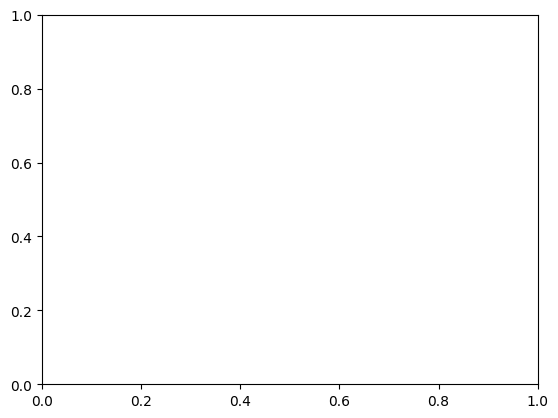

In [42]:
plt.annotate("r-squared = {:.3f}".format(r2_score(y_test, y_pred)), (0, 100000))

AttributeError: 'Series' object has no attribute 'reshape'

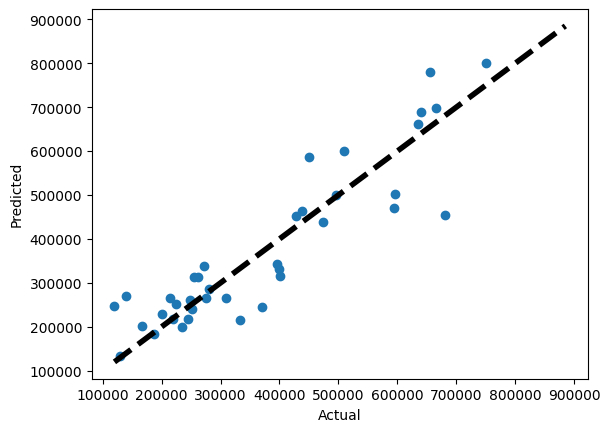

In [35]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
#regression line
y_test, y_pred = y_test.reshape(-1,1), y_pred.reshape(-1,1)
ax.plot(y_test, LinearRegression().fit(y_test, y_pred).predict(y_test))

plt.show()

In [43]:
df3 = [y_test,y_pred]

In [44]:
df3

[188      599999
 2084     805000
 1675    1275000
 1089     255000
 1378     380000
          ...   
 1356     550000
 394     1350000
 1543    1800000
 1402     615000
 39      1299000
 Name: Fiyat, Length: 682, dtype: int64,
 array([ 633872.25,  816781.1 , 1236089.8 ,  231382.97,  364592.94,
         219977.05, 1247067.8 ,  690535.75,  322692.97,  704427.3 ,
         426186.7 , 1112757.1 ,  643705.3 , 1080078.  ,  351218.3 ,
         584511.56,  628717.25,  346809.34, 1775809.5 ,  862531.9 ,
        6019907.  ,  357891.62,  361712.94,  946583.8 ,  730440.9 ,
        1255527.2 , 1160855.8 , 1307220.9 ,  355882.7 , 1176619.2 ,
         617014.44, 1502516.2 ,  759350.1 , 1484517.9 ,  994001.56,
        1526197.5 ,  724387.75,  466639.22,  316811.47, 1468103.5 ,
         947007.  , 1853116.8 ,  776243.9 , 1508593.2 ,  380782.2 ,
        1781466.2 ,  795592.75,  634111.44,  577672.56,  550114.44,
        2019220.1 , 1391381.  , 1246787.9 , 1306160.8 , 2559799.5 ,
         731153.4 ,  400

In [36]:
y_test2 = list(y_test)

In [ ]:
df3 = [y_test2, y_pred]

In [37]:
df3 = pd.DataFrame(list(zip(y_test, y_pred,(y_pred-y_test))),
               columns =['test', 'pred',"fark"])

In [47]:
df3

,test,pred,fark
0,599999,633872.250,33873.250
1,805000,816781.125,11781.125
2,1275000,1236089.750,-38910.250
3,255000,231382.969,-23617.031
4,380000,364592.938,-15407.062
...,...,...,...
677,550000,617777.062,67777.062
678,1350000,1153099.625,-196900.375
679,1800000,1510978.250,-289021.750
680,615000,710086.250,95086.250


In [38]:
df3["test"].max()

749750

In [40]:
df3[df3["test"]==749750]

,test,pred,fark
4,749750,800196.125,50446.125


In [41]:
df3.describe([0.05,0.25, 0.75,0.90,0.99]).T

,count,mean,std,min,5%,25%,50%,75%,90%,99%,max
test,38.000,372381.053,178536.318,120000.000,138500.000,237500.000,321500.000,490375.000,644500.000,723942.500,749750.000
pred,38.000,374880.594,179311.656,133655.938,196546.669,246021.770,313995.125,468510.961,668980.625,792592.186,800196.125
fark,38.000,2499.544,77915.693,-226440.188,-124536.738,-35988.840,8832.680,49878.141,100052.931,134554.074,137602.250


In [42]:
import joblib

In [43]:
marka_model = joblib.dump(grid_final_model, "Alfa Romeo.pkl")